# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,f1_score, roc_auc_score, roc_curve 
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, cross_val_score

Открываем файлы и сохраняем данные в датафреймы

In [2]:
df_geo1 = pd.read_csv('/datasets/geo_data_0.csv')
df_geo2 = pd.read_csv('/datasets/geo_data_1.csv')
df_geo3 = pd.read_csv('/datasets/geo_data_2.csv')

### Начальное изучение данных

In [3]:
df_geo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_geo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df_geo3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Признаки
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы).

Целевой признак
* `product` — объём запасов в скважине (тыс. баррелей).

###### Вывод
* пропусков данных не обнаружено 
* столбец `id` является уникальными идентификатором скважины и по своей сути дублирует индекс, данный столбец не пригодятся в обучение модели, поэтому его лучше удалить. 

Удалим столбeц `id` из каждого датафрейма

In [6]:
df_geo1 = df_geo1.drop('id', axis=1)
df_geo2 = df_geo2.drop('id', axis=1)
df_geo3 = df_geo3.drop('id', axis=1)

In [7]:
df_geo1.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [8]:
df_geo2.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [9]:
df_geo3.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


* Данные подготовлены, можно переходить к следующему этапу

## Обучение и проверка модели

### Разбивка данных на выборки

Извелекём из выборок признаки и целевой признак

In [10]:
features_geo1 = df_geo1.drop('product', axis=1)
features_geo2 = df_geo2.drop('product', axis=1)
features_geo3 = df_geo3.drop('product', axis=1)

In [11]:
target_geo1 = df_geo1['product']
target_geo2 = df_geo2['product']
target_geo3 = df_geo3['product']

Разобьём наши выборки на обучающие и валидационные, в соотношение 3 к 1. 

In [12]:
features_geo1_train, features_geo1_valid, features_geo2_train, features_geo2_valid, features_geo3_train, features_geo3_valid,\
target_geo1_train, target_geo1_valid, target_geo2_train, target_geo2_valid,target_geo3_train, target_geo3_valid\
= train_test_split(features_geo1, features_geo2, features_geo3, target_geo1, target_geo2, target_geo3,\
test_size=0.25, random_state=12345)

Проверим итоговые размеры и соотношения полученных выборок

In [13]:
print(f'Итоговые размеры выборок для первого региона, обучающая:валидационная: {target_geo1_train.count()}\
:{target_geo1_valid.count()}')
print(f'Итоговые размеры выборок для второго региона, обучающая:валидационная: {target_geo2_train.count()}\
:{target_geo2_valid.count()}')
print(f'Итоговые размеры выборок для третьего региона, обучающая:валидационная: {target_geo3_train.count()}\
:{target_geo3_valid.count()}')

Итоговые размеры выборок для первого региона, обучающая:валидационная: 75000:25000
Итоговые размеры выборок для второго региона, обучающая:валидационная: 75000:25000
Итоговые размеры выборок для третьего региона, обучающая:валидационная: 75000:25000


Обнулим индексы у ключевых признаков

In [14]:
target_geo1_valid = target_geo1_valid.reset_index(drop=True)
target_geo2_valid = target_geo2_valid.reset_index(drop=True)
target_geo3_valid = target_geo3_valid.reset_index(drop=True)

### Обучение модели

* обучим модель линейной регрессии для каждого региона и сделаем предсказания на валидационной выборке;
* найдем RMSE моделей.

In [15]:
model = LinearRegression()

#### Регион №1

In [16]:
model.fit(features_geo1_train, target_geo1_train)
predicted_valid_geo1 = model.predict(features_geo1_valid)
mse_geo1 = mean_squared_error(target_geo1_valid, predicted_valid_geo1)
print(f'Cредний запас предсказанного сырья: {np.mean(predicted_valid_geo1):.2f} тыс. баррелей')
print("RMSE =", round(mse_geo1 ** 0.5, 2))

Cредний запас предсказанного сырья: 92.59 тыс. баррелей
RMSE = 37.58


#### Регион №2

In [17]:
model.fit(features_geo2_train, target_geo2_train)
predicted_valid_geo2 = model.predict(features_geo2_valid)
mse_geo2 = mean_squared_error(target_geo2_valid, predicted_valid_geo2)
print(f'Cредний запас предсказанного сырья: {np.mean(predicted_valid_geo2):.2f} тыс. баррелей')
print("RMSE =", round(mse_geo2 ** 0.5, 2))

Cредний запас предсказанного сырья: 68.73 тыс. баррелей
RMSE = 0.89


#### Регион №3

In [18]:
model.fit(features_geo3_train, target_geo3_train)
predicted_valid_geo3 = model.predict(features_geo3_valid)
mse_geo3 = mean_squared_error(target_geo3_valid, predicted_valid_geo3)
print(f'Cредний запас предсказанного сырья: {np.mean(predicted_valid_geo3):.2f} тыс. баррелей')
print("RMSE =", round(mse_geo3 ** 0.5, 2))

Cредний запас предсказанного сырья: 94.97 тыс. баррелей
RMSE = 40.03


Преобразуем пресказанные значения объёма сырья в Series для удобства вычеслений

In [19]:
predicted_valid_geo1 = pd.Series(predicted_valid_geo1)
predicted_valid_geo2 = pd.Series(predicted_valid_geo2)
predicted_valid_geo3 = pd.Series(predicted_valid_geo3)

###### Вывод

* средний запаса предсказанного сырья выше всего в регионе №3 - 94,97 тыс. баррелей, в регионе №2 - 92.59 тыс. баррелей, а меньше всего в регионе №3 - 68.73 тыс. баррелей;
* RMSE меньше всего во втором регионе: 0.89 - это очень хороший результат, модель даёт точные результаты. В регионе №2 и №3, значение RMSE высокие: 37.58 и 40.03, модель даёт не точные результаты.

## Подготовка к расчёту прибыли

 Сохраним все ключевые значения для расчётов в отдельных переменных

In [20]:
budget = 10000000 # бюджет в тыс. рублей
unit_price = 450 # доход с тыс. бареллей, в тыс. рублей
count_invest_wells = 500 # кол-во исследуемых точек
count_develop_wells = 200 # кол-во отбираемых лучшех точек
confidence_interval = 0.95 # доверительный интервал

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [21]:
print(f'Минимальный средний объём сырья достаточный для бузубыточной разработки новой скважины: '
      f'{(budget / count_develop_wells / unit_price):.2f} тыс. барелль')

Минимальный средний объём сырья достаточный для бузубыточной разработки новой скважины: 111.11 тыс. барелль


###### Вывод

* Во всех регионах средний запас предсказанного сырья, меньше минимального среднего объёма сырья достаточного для безубыточной разработки новой скважины (111.11 тыс. барелль)

Напишём функцию для подсчёта прибыли по выбранным скважинам и предсказаниям модели

In [22]:
def profit_well(target, predict, count, budget, unit_price):
    predict_sort = predict.sort_values(ascending=False)
    target_top = target[predict_sort.index][:count]
    return (target_top.sum() * unit_price - budget) / 1000  

## Расчёт прибыли и рисков 

In [23]:
state = np.random.RandomState(12345)

### Регион №1

С помощью техники Bootstrap создадим 1000 выборок, чтобы найти распределение прибыли.

In [24]:
profit_geo1 = []
for i in range(1000):
    sub_predicted_valid_geo1 = predicted_valid_geo1.sample(count_invest_wells, replace=True, random_state=state)
    profit = profit_well(target_geo1_valid, sub_predicted_valid_geo1, count_develop_wells, budget, unit_price)
    profit_geo1.append(profit)

Преобразуем полученную выборку в Series, для удобства вычислений

In [25]:
profit_geo1 = pd.Series(profit_geo1)

Построим график распределения прибыли

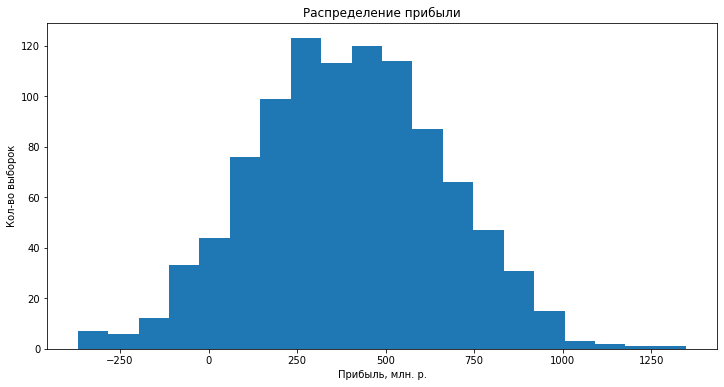

In [26]:
plt.figure(figsize=(12, 6))
profit_geo1.plot( kind='hist', bins=20)
plt.xlabel("Прибыль, млн. р.")
plt.ylabel("Кол-во выборок")
plt.title("Распределение прибыли")
plt.show()

* Прибыль распределена нормально

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [27]:
print(f'Средняя прибыль: {profit_geo1.mean():.2f} млн. руб.')
print(f'95%-й доверительный интервал: от {profit_geo1.quantile((1-confidence_interval)/2):.2f} до '
     f'{profit_geo1.quantile(0.5+confidence_interval/2):.2f} млн. руб.')
print(f'Риск убытков: {(profit_geo1.values < 0).mean():.2%}')

Средняя прибыль: 396.16 млн. руб.
95%-й доверительный интервал: от -111.22 до 909.77 млн. руб.
Риск убытков: 6.90%


###### Вывод
* Средняя прибыль находится в положительной зоне - 396.16 млн. руб., но риск убытков выше установленной планки в 2,5%, он равен 6,9%. Следовательно данный регион нам не подходит по уровню риска.

### Регион №2

С помощью техники Bootstrap создадим 1000 выборок, чтобы найти распределение прибыли.

In [28]:
profit_geo2 = []
for i in range(1000):
    sub_predicted_valid_geo2 = predicted_valid_geo2.sample(count_invest_wells, replace=True, random_state=state)
    profit = profit_well(target_geo2_valid, sub_predicted_valid_geo2, count_develop_wells, budget, unit_price)
    profit_geo2.append(profit)

Преобразуем полученную выборку в Series, для удобства вычислений

In [29]:
profit_geo2 = pd.Series(profit_geo2)    

Построим график распределения прибыли

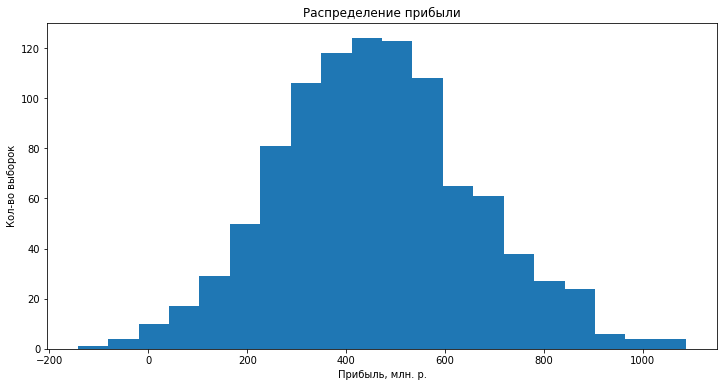

In [30]:
plt.figure(figsize=(12, 6))
profit_geo2.plot( kind='hist', bins=20)
plt.xlabel("Прибыль, млн. р.")
plt.ylabel("Кол-во выборок")
plt.title("Распределение прибыли")
plt.show()

* Прибыль распределена нормально

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [31]:
print(f'Средняя прибыль: {profit_geo2.mean():.2f} млн. руб.')
print(f'95%-й доверительный интервал: от {profit_geo2.quantile((1-confidence_interval)/2):.2f} до '
     f'{profit_geo2.quantile(0.5+confidence_interval/2):.2f} млн. руб.')
print(f'Риск убытков: {(profit_geo2.values < 0).mean():.2%}')

Средняя прибыль: 461.16 млн. руб.
95%-й доверительный интервал: от 78.05 до 862.95 млн. руб.
Риск убытков: 0.70%


###### Вывод
* Средняя прибыль находится в положительной зоне - 461.16 млн. руб;
* Риск убытков ниже установленной планки в 2,5%, он равен 0,7%.

### Регион №3

С помощью техники Bootstrap создадим 1000 выборок, чтобы найти распределение прибыли.

In [32]:
profit_geo3 = []
for i in range(1000):
    sub_predicted_valid_geo3 = predicted_valid_geo3.sample(count_invest_wells, replace=True, random_state=state)
    profit = profit_well(target_geo3_valid, sub_predicted_valid_geo3, count_develop_wells, budget, unit_price)
    profit_geo3.append(profit)

Преобразуем полученную выборку в Series, для удобства вычислений

In [33]:
profit_geo3 = pd.Series(profit_geo3)   

Построим график распределения прибыли

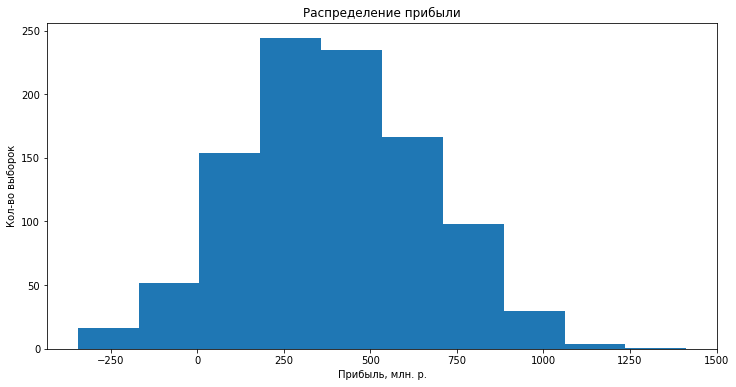

In [34]:
plt.figure(figsize=(12, 6))
profit_geo3.plot( kind='hist', bins=10)
plt.xlabel("Прибыль, млн. р.")
plt.ylabel("Кол-во выборок")
plt.title("Распределение прибыли")
plt.show()

* Прибыль распределена нормально

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [35]:
print(f'Средняя прибыль: {profit_geo3.mean():.2f} млн. руб.')
print(f'95%-й доверительный интервал: от {profit_geo3.quantile((1-confidence_interval)/2):.2f} до '
     f'{profit_geo3.quantile(0.5+confidence_interval/2):.2f} млн. руб.')
print(f'Риск убытков: {(profit_geo3.values < 0).mean():.2%}')

Средняя прибыль: 392.95 млн. руб.
95%-й доверительный интервал: от -112.23 до 934.56 млн. руб.
Риск убытков: 6.50%


###### Вывод
* Средняя прибыль находится в положительной зоне - 392.95 млн. руб., но риск убытков выше установленной планки в 2,5%, он равен 6,5%. Следовательно данный регион нам не подходит по уровню риска.

## Общий вывод

* Из трех ислледованных регионов, нам подходит только регион №2, так как только в нём риск убытков ниже установленной планки в 2,5% и равняется 0,7%. Так же в данном регионе самый высокий показатель средней прибыли -  461.16 млн. руб.
* Регионы №1 и №3 не подходят по уровню риска, у них он равен 6,9% и 6,5% соответственно. Средняя прибыль в данных регионах меньше чем в регионе №2 и равняется 396.16 и 392.95 млн. руб. соответственно.